# Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, accuracy_score

from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

# Load and Explore the Dataset


In [17]:
# Load the dataset
df = pd.read_csv("creditcard_2023.csv")

# Change the columm Class to Fraud
df.rename(columns={'Class': 'Fraud'}, inplace=True)

# Display first few rows
df.head()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Debugging
# Display basic statistics
print("\nDataset Statistics:\n", df.describe())

# Check class distribution
print("\nClass Distribution:\n", df['Fraud'].value_counts())


Missing values:
 id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Fraud     0
dtype: int64

Dataset Statistics:
                   id            V1            V2            V3            V4  \
count  568630.000000  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   284314.500000 -5.638058e-17 -1.319545e-16 -3.518788e-17 -2.879008e-17   
std    164149.486122  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min         0.000000 -3.495584e+00 -4.996657e+01 -3.183760e+00 -4.951222e+00   
25%    142157.250000 -5.652859e-01 -4.866777e-01 -6.492987e-01 -6.560203e-01   
50%    284314.500000 -9.363846e-02 -1.358939e-01  3.528579e-04 -7.376152e-02   
75%    426471.7

# Visualization of Dataset


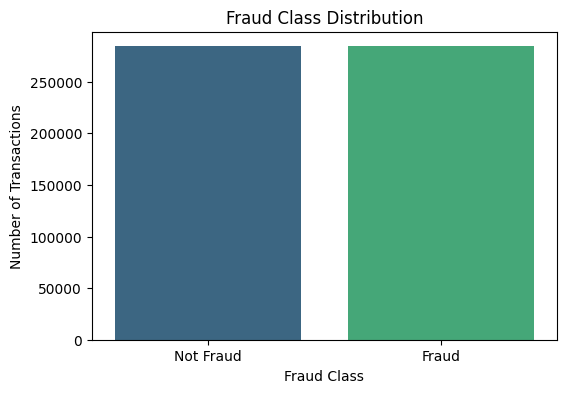

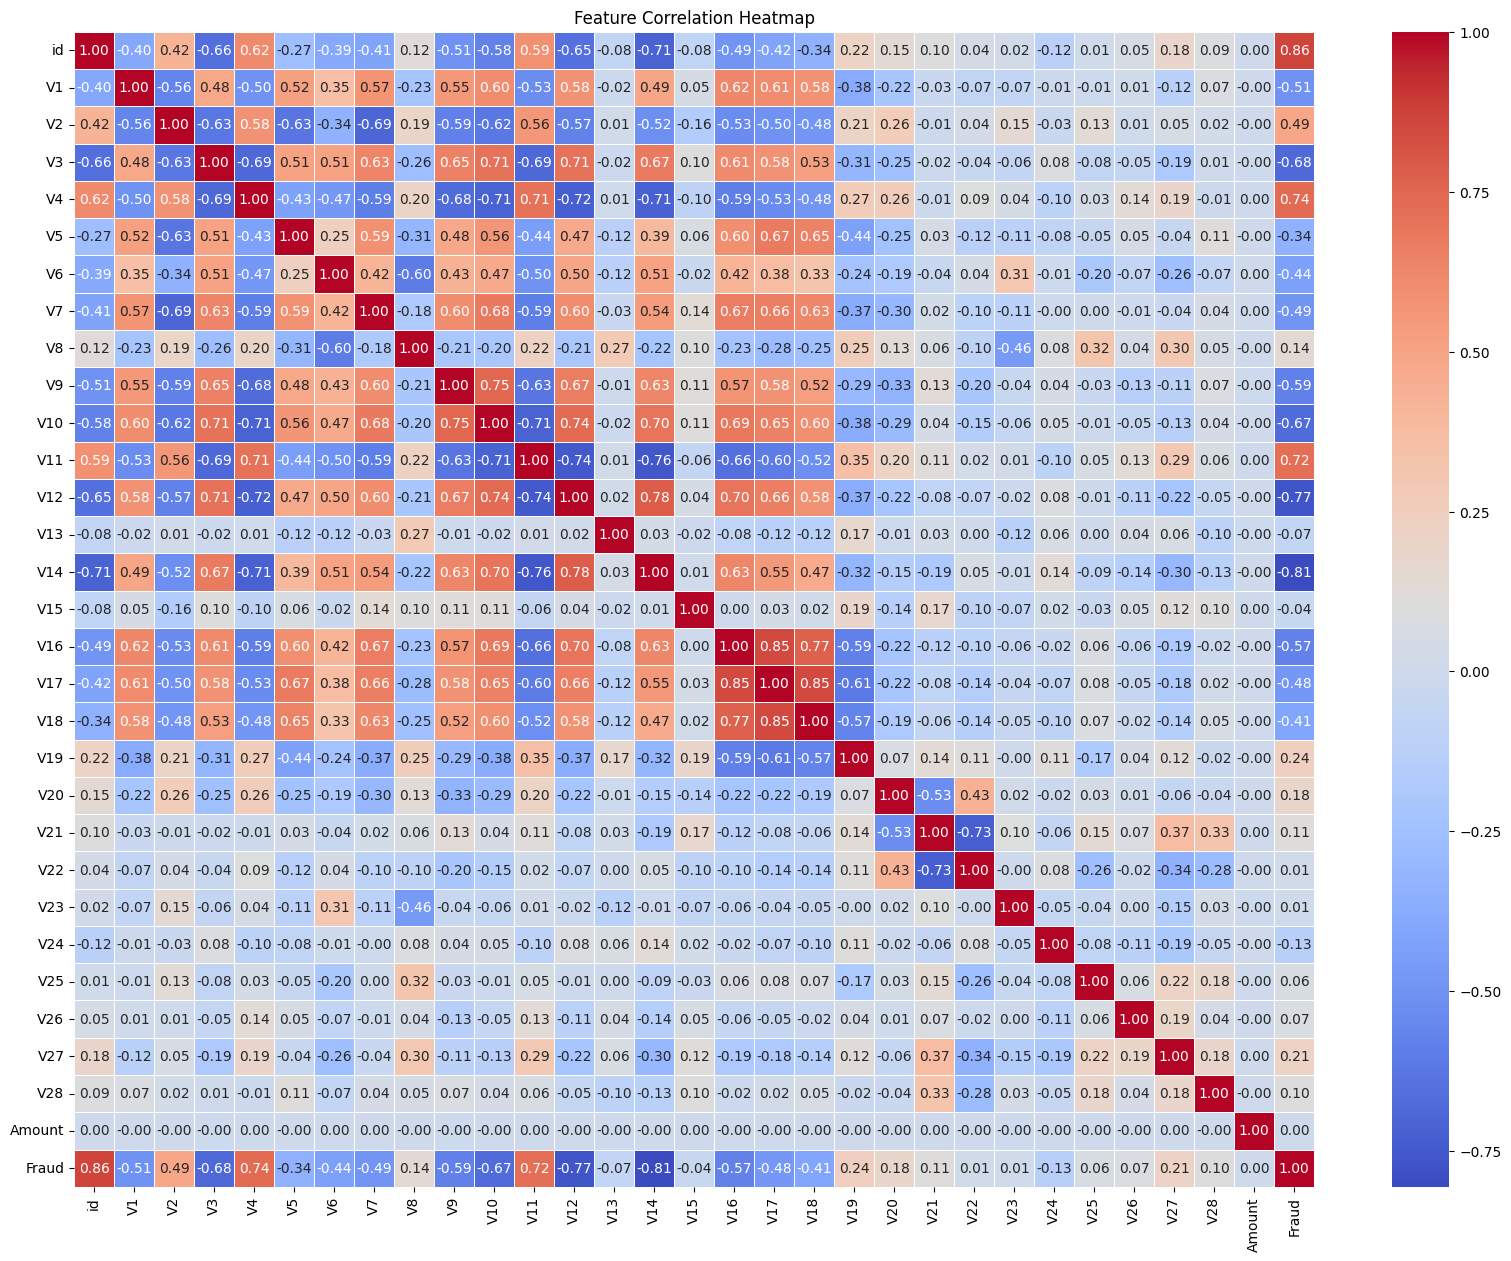

In [18]:
# Fraud Class Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=df["Fraud"].value_counts().index,
            y=df["Fraud"].value_counts().values,
            hue=df["Fraud"].value_counts().index,
            palette="viridis",
            legend=False)

plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.ylabel("Number of Transactions")
plt.xlabel("Fraud Class")
plt.title("Fraud Class Distribution")
plt.show()

# Select only numeric columns for correlation computation
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Feature Correlation Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Data Preprocessing

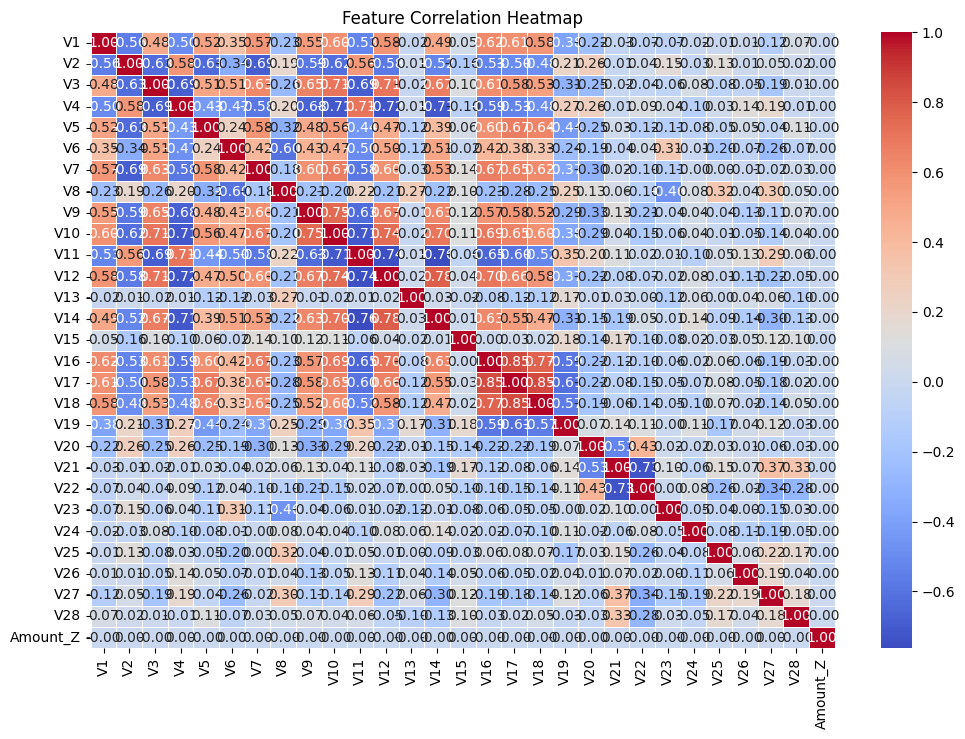

In [19]:
# Feature Engineering - Alternative Features
# 1. Standardize Transaction Amount
scaler = RobustScaler()         # Swap scaler to emphasize higher amounts
df["Amount_Z"] = scaler.fit_transform(df[["Amount"]])


df.drop(columns=["id", "Amount"], inplace=True)

# Separate features and target variable
df = df.dropna(subset=['Fraud'])  # Remove rows where 'Fraud' is NaN
X = df.drop(columns=['Fraud'])
y = df['Fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame for feature selection (without SMOTE)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Normalize features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Final correlation heatmap
# Compute correlation matrix for the final features
correlation_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature Importance


Retained Top Features: ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


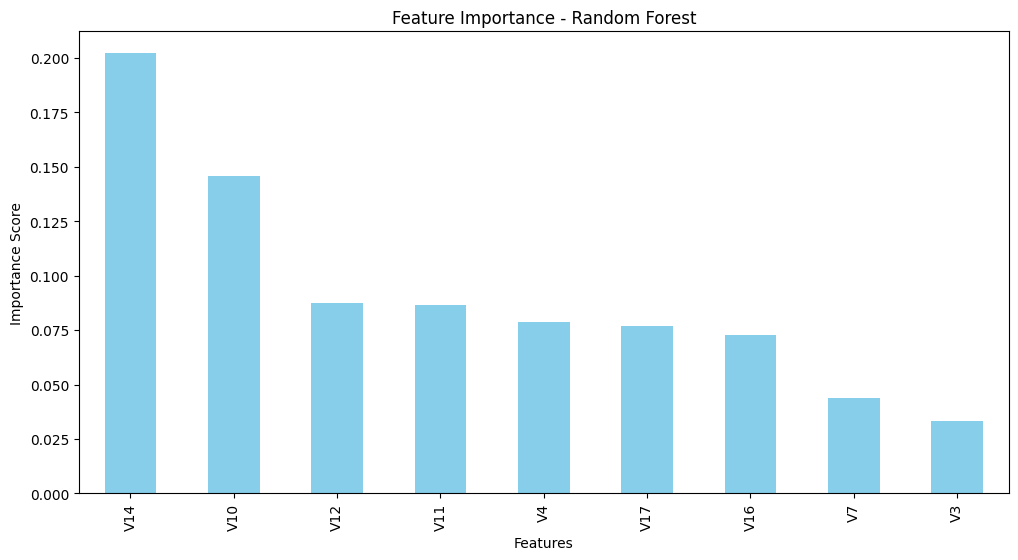

In [25]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Train temporary Random Forest model for feature selection
rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")
rf_temp.fit(X_train_np, y_train_np)

# Extract Feature Importances
feature_importances = rf_temp.feature_importances_

# Convert to NumPy array for speed
feature_importances_np = np.array(feature_importances)

# Set a threshold (keep features with importance > 0.02)
selected_features_idx = np.where(feature_importances_np > 0.02)[0]

# Retain only important features
X_train_np = X_train_np[:, selected_features_idx]
X_test_np = X_test_np[:, selected_features_idx]

# Get feature names (if needed)
top_features = np.array(X.columns)[selected_features_idx]
print("\nRetained Top Features:", list(top_features))

# Create a Pandas Series for easy sorting
feature_importance_series = pd.Series(feature_importances_np[selected_features_idx], index=top_features)

# Sort in descending order and plot
plt.figure(figsize=(12, 6))
feature_importance_series.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

# Hyperparameter Tuning

In [ ]:
# Define the parameter grid (smaller search space)
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize the Random Forest model with fewer trees
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced", n_jobs=-1)

# Use HalvingGridSearchCV for faster tuning
halving_search = HalvingGridSearchCV(
    rf, param_grid, cv=3, factor=3, n_jobs=-1, verbose=1, random_state=42
)

# Fit the model with fewer trees for faster tuning
halving_search.fit(X_train_np, y_train_np)

# Get best parameters and retrain with full trees
best_params = halving_search.best_params_
best_params['n_estimators'] = 300  # Increase trees for final model

# Train final model with optimal hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train_np, y_train_np)

# Print final model score
print("Best Parameters:", best_params)
print("Final Model Accuracy:", best_rf_model.score(X_test_np, y_test_np))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 5616
max_resources_: 454904
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 5616
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 1
n_candidates: 36
n_resources: 16848
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 12
n_resources: 50544
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 4
n_resources: 151632
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 454896
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Final Model Accuracy: 0.9995427606703832


# Model Evaluation




Best Threshold for F1-Score: 0.57

Random Forest Accuracy: 0.9996


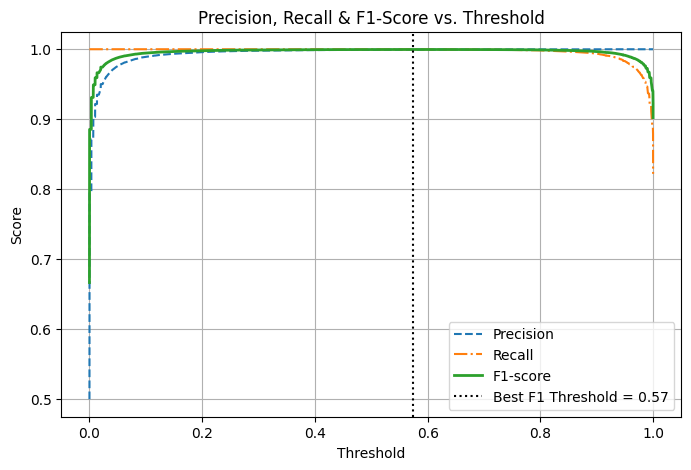


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


Confusion Matrix:
[[56828    35]
 [    8 56855]]

Precision-Recall AUC Score: 0.9999738256769747


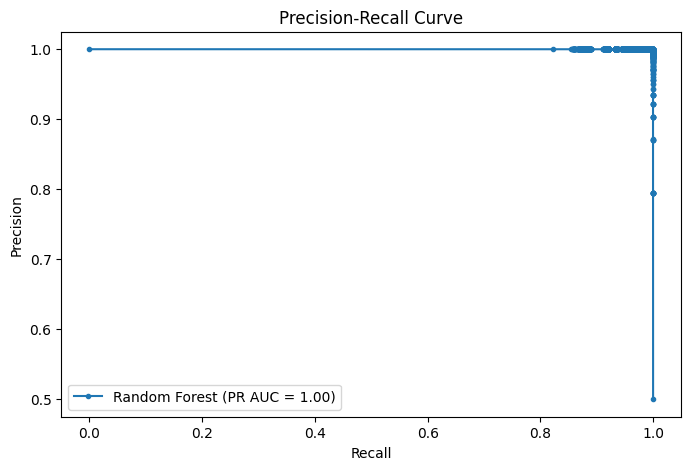


OOB Score: 0.9996878462268962


In [22]:
# Model Evaluation (Updated)
# Make Predictions
y_pred_proba = best_rf_model.predict_proba(X_test_np)[:, 1]  # Get probability scores

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred_proba)

# Find Best Threshold (Maximizing F1-Score)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print(f"\nBest Threshold for F1-Score: {best_threshold:.2f}")

# Convert Probabilities into Binary Predictions Using Best Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test_np, y_pred_adjusted)

# Print accuracy
print(f"\nRandom Forest Accuracy: {accuracy:.4f}")

# Plot Precision-Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recall[:-1], label="Recall", linestyle="-.")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", linestyle="-", linewidth=2)
plt.axvline(best_threshold, color='black', linestyle="dotted", label=f"Best F1 Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1-Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# Apply New Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Evaluate Performance
print("\nClassification Report")
print(classification_report(y_test_np, y_pred_adjusted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_adjusted))

# Compute Precision-Recall AUC
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC Score:", pr_auc)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label="Random Forest (PR AUC = {:.2f})".format(pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Out-of-Bag Score (Alternative Validation)
rf_oob_model = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, n_jobs=-1)
rf_oob_model.fit(X_train_np, y_train_np)

# Print OOB Score
print("\nOOB Score:", rf_oob_model.oob_score_)

# ROC Curve Visualization

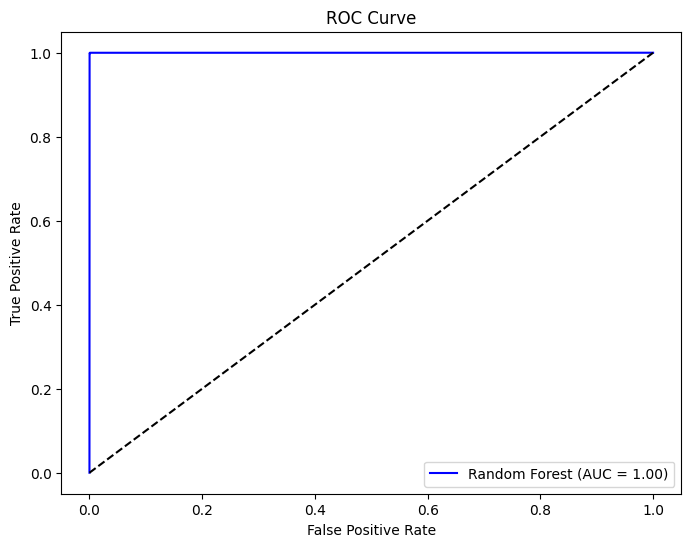

In [23]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test_np, y_pred_proba)), color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()